<a href="https://colab.research.google.com/github/ZahraFarahzadii/VAE-CVAE/blob/main/conditional_variational_autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#import libraries
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Model
from keras import backend as K
from keras import objectives
from keras.utils import to_categorical
from scipy.stats import norm
from keras.datasets import mnist
from keras.layers import Input, Dense, Lambda, concatenate
from keras.models import Model

In [ ]:
#load data and normalization
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train.astype('float32')/255., x_test.astype('float32')/255.
x_train, x_test = x_train.reshape(x_train.shape[0], -1), x_test.reshape(x_test.shape[0], -1)
y_train, y_test = to_categorical(y_train), to_categorical(y_test)

In [ ]:
# define some constansts
batch_size=50
epoch=50

In [ ]:
# encoder
x = Input(shape=(x_train.shape[1:]))
condition = Input(shape=(y_train.shape[1],))
n_hidden=512
z_dim=2
inputs = concatenate([x, condition])
x_encoded = Dense(n_hidden, activation='relu')(inputs)
x_encoded = Dense(n_hidden//2, activation='relu')(x_encoded)
mu = Dense(z_dim, activation='linear')(x_encoded)
log_var = Dense(z_dim, activation='linear')(x_encoded)

We create a sampling function to randomly sample from the distribution of the two-dimensional data generating in the encoder part

In [ ]:
def sampling(args):
    mu, log_var = args
    batch_size=50
    eps = K.random_normal(shape=(batch_size, z_dim), mean=0., stddev=1.0)
    return mu + K.exp(log_var/2.) * eps

z = Lambda(sampling, output_shape=(z_dim,))([mu, log_var])
z_cond = concatenate([z, condition])

In [ ]:
#decoder
z_decoder1 = Dense(n_hidden//2, activation='relu')
z_decoder2 = Dense(n_hidden, activation='relu')
y_decoder = Dense(x_train.shape[1], activation='sigmoid')

z_decoded = z_decoder1(z_cond)
z_decoded = z_decoder2(z_decoded)
y = y_decoder(z_decoded)

In [ ]:
#define loss function
reconstruction_loss = objectives.binary_crossentropy(x, y) * x_train.shape[1]
kl_loss = 0.5 * K.sum(K.square(mu) + K.exp(log_var) - log_var - 1, axis = -1)
cvae_loss = reconstruction_loss + kl_loss

#define cave model
cvae = Model([x, condition], y)
cvae.add_loss(cvae_loss)
cvae.compile(optimizer='adam')
cvae.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 784)]        0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 10)]         0                                            
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 794)          0           input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, 512)          407040      concatenate[0][0]            

In [ ]:
# train cvae
history=cvae.fit([x_train, y_train],
       shuffle=True,
       epochs=epoch,
       batch_size=batch_size,
       validation_data=([x_test, y_test], None))

Epoch 1/100
1200/1200 [==============================] - 16s 14ms/step - loss: 124.2852 - val_loss: 127.7639
Epoch 2/100
1200/1200 [==============================] - 16s 13ms/step - loss: 124.1909 - val_loss: 127.9756
Epoch 3/100
1200/1200 [==============================] - 16s 13ms/step - loss: 124.0566 - val_loss: 128.2265
Epoch 4/100
1200/1200 [==============================] - 16s 13ms/step - loss: 123.9977 - val_loss: 127.9799
Epoch 5/100
1200/1200 [==============================] - 16s 13ms/step - loss: 123.8547 - val_loss: 127.7550
Epoch 6/100
1200/1200 [==============================] - 16s 13ms/step - loss: 123.8353 - val_loss: 127.8211
Epoch 7/100
1200/1200 [==============================] - 17s 14ms/step - loss: 123.7326 - val_loss: 127.8261
Epoch 8/100
1200/1200 [==============================] - 17s 14ms/step - loss: 123.6606 - val_loss: 127.9316
Epoch 9/100
1200/1200 [==============================] - 16s 13ms/step - loss: 123.5508 - val_loss: 127.6062
Epoch 10/100
1200/1

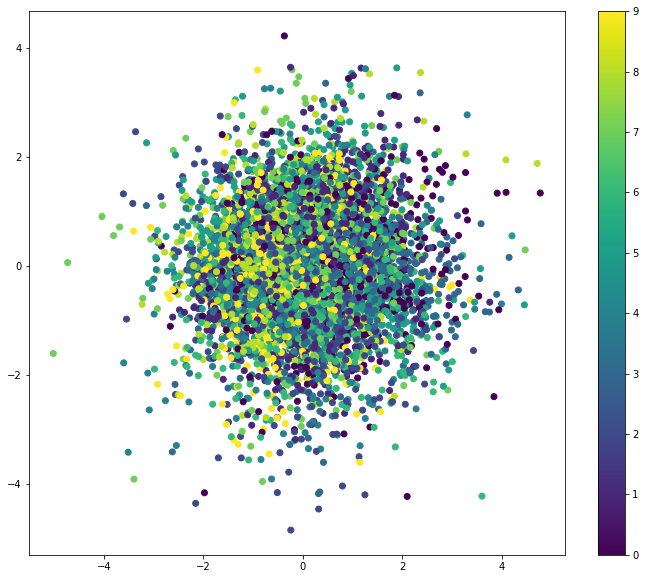

In [ ]:
# Plot of the digit classes in the latent space
encoder = Model([x, condition], mu)
te_latent = encoder.predict([x_test, y_test], batch_size=batch_size)
plt.figure(figsize=(12, 10))
plt.scatter(te_latent[:, 0], te_latent[:, 1], c=np.argmax(y_test, axis=1))
plt.colorbar()
plt.show()

In [ ]:
#build decoder
decoder_input = Input(shape=(z_dim+y_train.shape[1],))
_z_decoded = z_decoder1(decoder_input)
_z_decoded = z_decoder2(_z_decoded)
_y = y_decoder(_z_decoded)
generator = Model(decoder_input, _y)
generator.summary()

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 12)]              0         
_________________________________________________________________
dense_6 (Dense)              multiple                  3328      
_________________________________________________________________
dense_7 (Dense)              multiple                  131584    
_________________________________________________________________
dense_8 (Dense)              multiple                  402192    
Total params: 537,104
Trainable params: 537,104
Non-trainable params: 0
_________________________________________________________________


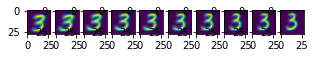

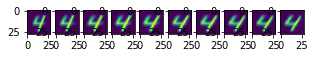

In [ ]:
# display a 2D manifold of the digits
# exploring the latent space: change z sample on the x-axis
digit_size = 28
for cond_num in range(3,5):
    condition_num = to_categorical(cond_num, 10).reshape(1,-1)
    plt.figure(figsize=(10, 2))

    for i in range(10):
        plt.subplot(1, 20, i+1)
        z_sample = np.array([[0.25*i, 0.25]])
        x_decoded = generator.predict(np.column_stack([z_sample, condition_num]))
        digit = x_decoded[0].reshape(digit_size, digit_size)
        plt.imshow(digit)



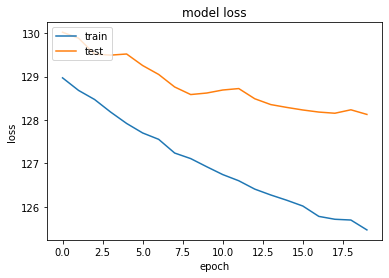

In [ ]:
# Plot loss diagram
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()